In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from sklearn.neural_network import MLPRegressor

In [2]:
from sentinelhub import SHConfig
from os import environ

sh_config = SHConfig()
sh_config.instance_id=environ['SH_INSTANCE_ID']
sh_config.sh_client_id=environ['SH_CLIENT_ID']
sh_config.sh_client_secret=environ['SH_CLIENT_SECRET']

from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, OverwritePermission
from eolearn.io.processing_api import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask
from eolearn.geometry import VectorToRaster

from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from skimage.filters import threshold_otsu
import shapely.wkt
from shapely.geometry import Polygon
from sentinelhub import BBox, CRS, DataCollection

In [3]:
df = pd.read_csv('./data/01_removed_outliers/Lake_Bilancino.csv', sep=',', header=0, index_col=0)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index('Date', verify_integrity=True)
df

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2002-06-03,NaN,NaN,NaN,NaN,NaN,NaN,249.43,NaN
2002-06-04,NaN,NaN,NaN,NaN,NaN,NaN,249.43,NaN
2002-06-05,NaN,NaN,NaN,NaN,NaN,NaN,249.43,NaN
2002-06-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,NaN
2002-06-07,NaN,NaN,NaN,NaN,NaN,NaN,249.44,NaN
...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.6
2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.6
2020-06-28,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.6


<AxesSubplot:>

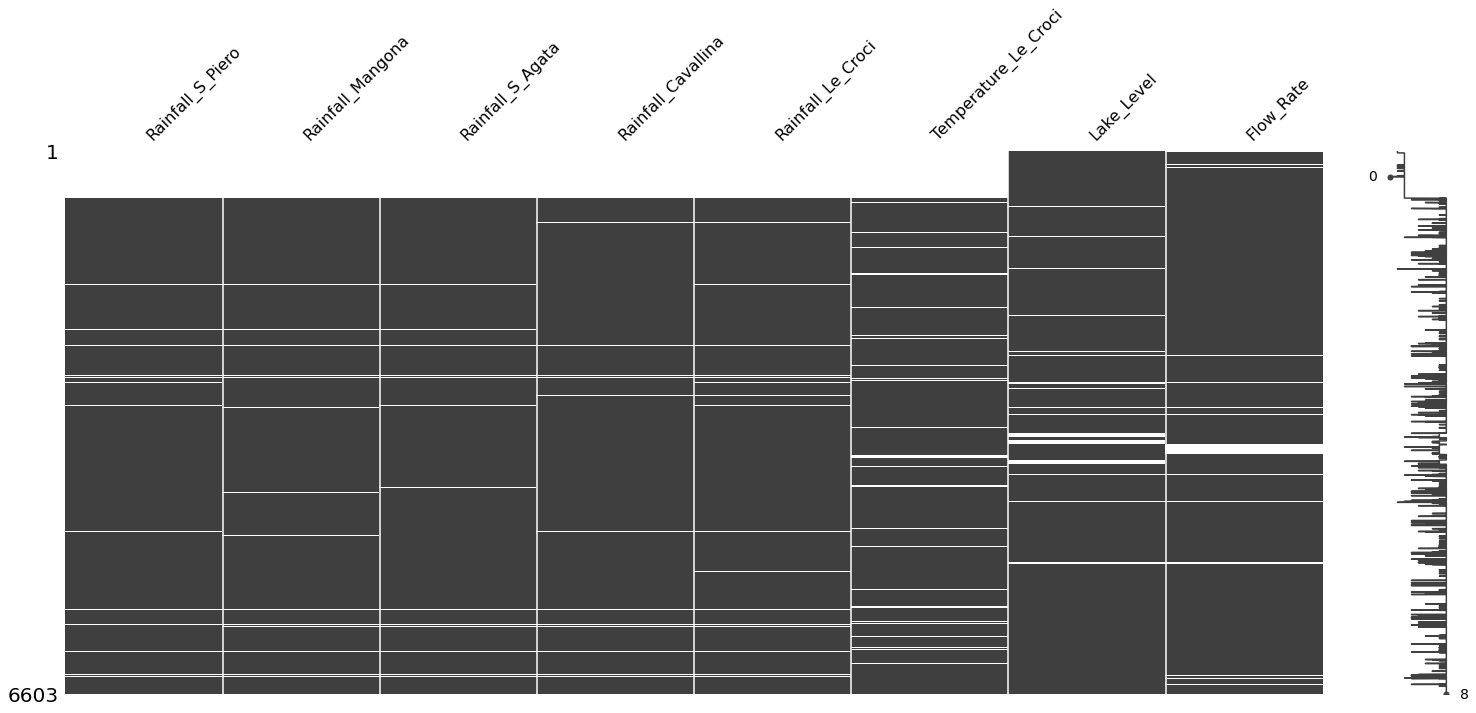

In [4]:
# outliers were removed in previous step
msno.matrix(df)

In [5]:
# we cut out top rows with most missing values
df = df[df.index >= pd.to_datetime('2004-01-01')]
df

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2004-01-01,0.0,0.0,0.4,0.0,0.0,NaN,251.14,0.5
2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,251.21,0.5
2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,251.28,0.5
2004-01-04,0.0,0.0,0.0,0.0,0.0,NaN,251.35,0.5
2004-01-05,0.2,0.0,0.0,0.0,0.0,NaN,251.37,0.5
...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.6
2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.6
2020-06-28,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.6


,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Rainfall_S_Piero,1.000000,0.805152,0.860220,0.869389,0.862395,-0.143844,-0.005017,0.062759
Rainfall_Mangona,0.805152,1.000000,0.814781,0.823178,0.820839,-0.153080,-0.016338,0.077262
Rainfall_S_Agata,0.860220,0.814781,1.000000,0.850801,0.854746,-0.150761,-0.003793,0.084660
Rainfall_Cavallina,0.869389,0.823178,0.850801,1.000000,0.894008,-0.134049,-0.014958,0.068350
Rainfall_Le_Croci,0.862395,0.820839,0.854746,0.894008,1.000000,-0.152530,-0.017926,0.078491
Temperature_Le_Croci,-0.143844,-0.153080,-0.150761,-0.134049,-0.152530,1.000000,0.081849,-0.198726
Lake_Level,-0.005017,-0.016338,-0.003793,-0.014958,-0.017926,0.081849,1.000000,0.262826
Flow_Rate,0.062759,0.077262,0.084660,0.068350,0.078491,-0.198726,0.262826,1.000000


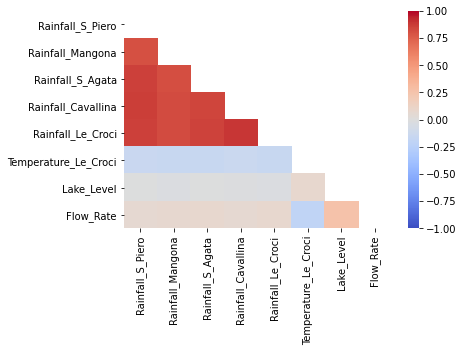

In [6]:
def correlation_matrix(df):
    corr = df.corr(method='pearson')
    sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='coolwarm')
    return corr

correlation_matrix(df)

In [7]:
# Correlated rainfal are redundant we keep just Cavallina rainfall because it is located next the lake.
df = df.drop(['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Le_Croci'], axis=1, errors='ignore')
df

,Rainfall_Cavallina,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,
2004-01-01,0.0,NaN,251.14,0.5
2004-01-02,0.0,6.50,251.21,0.5
2004-01-03,0.0,4.45,251.28,0.5
2004-01-04,0.0,NaN,251.35,0.5
2004-01-05,0.0,NaN,251.37,0.5
...,...,...,...,...
2020-06-26,0.0,22.50,250.85,0.6
2020-06-27,0.0,23.40,250.84,0.6
2020-06-28,0.0,21.50,250.83,0.6


<AxesSubplot:xlabel='Date'>

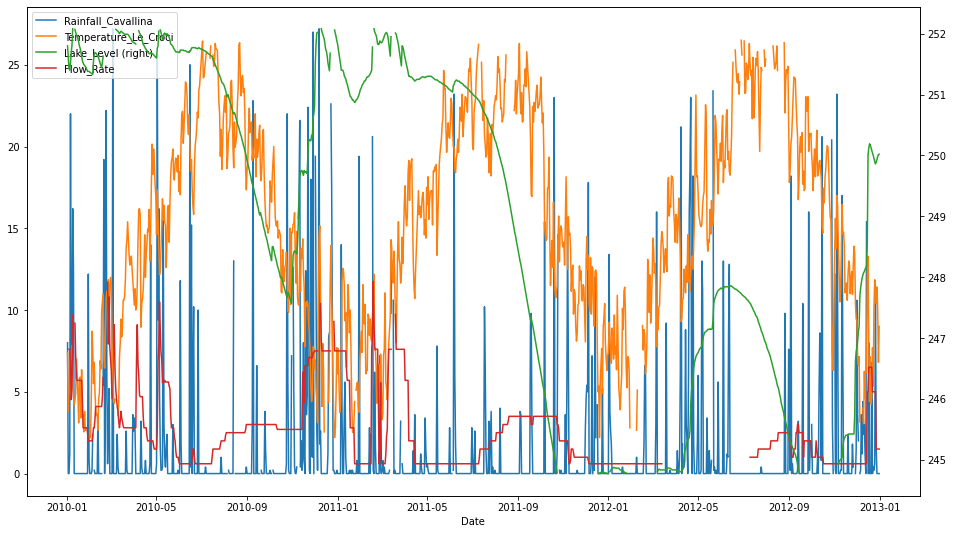

In [8]:
df[
    (df.index > pd.to_datetime('2010-01-01')) &
    (df.index < pd.to_datetime('2013-01-01'))
].plot(secondary_y=['Lake_Level'], figsize=(16, 9))

,Rainfall_Cavallina,Temperature_Le_Croci,Lake_Level,Flow_Rate,month
Rainfall_Cavallina,1.000000,-0.134049,-0.014958,0.068350,-0.010086
Temperature_Le_Croci,-0.134049,1.000000,0.081849,-0.198726,0.233523
Lake_Level,-0.014958,0.081849,1.000000,0.262826,-0.501790
Flow_Rate,0.068350,-0.198726,0.262826,1.000000,-0.145956
month,-0.010086,0.233523,-0.501790,-0.145956,1.000000


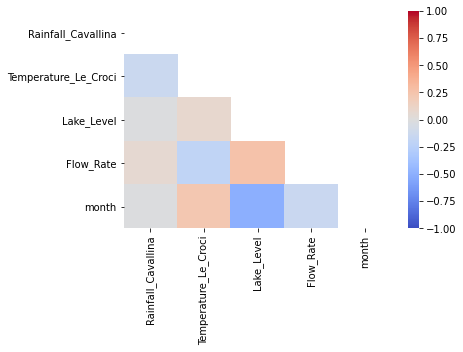

In [9]:
df['month'] = pd.to_datetime(df.index).month
# Month has negative correlation with lake level
correlation_matrix(df)

In [10]:
# Spliting data for models

split = df[df.index == pd.to_datetime('2018-01-01')].index[0]

d = df.dropna()

lrn = d.drop(['Lake_Level'], axis=1)
tgt = d['Lake_Level']

lrn_input = lrn[lrn.index < split]
lrn_output = tgt[tgt.index < split]

tgt_input = lrn[lrn.index >= split]
tgt_output = tgt[tgt.index >= split]

def run_model(model):
    model.fit(lrn_input, lrn_output)
    result = pd.DataFrame({ 'Predictions': model.predict(tgt_input), 'Lake_Level': tgt_output })
    return result

def evaluate(result):
    result = result.dropna()
    print('   MAE: {}'.format(mean_absolute_error(result['Predictions'], result['Lake_Level'])))
    print('   RMAE: {}'.format(mean_squared_error(result['Predictions'], result['Lake_Level'])))

   MAE: 0.7338695253684856
   RMAE: 0.7700302967849726


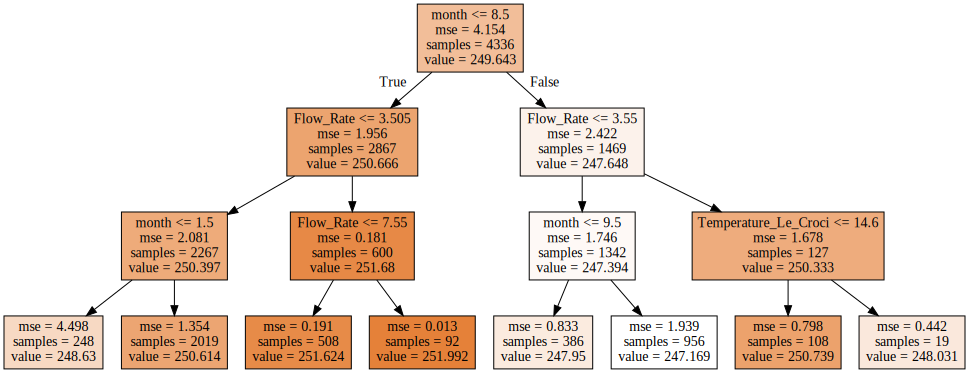

<AxesSubplot:title={'center':'Decision tree'}, xlabel='Date'>

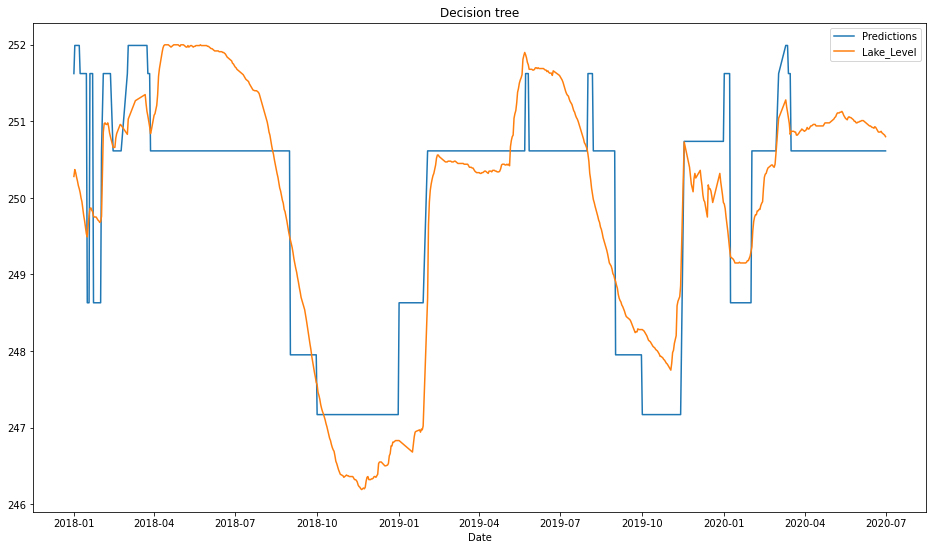

In [11]:
dtr = tree.DecisionTreeRegressor(max_depth=3)

dtr_result = run_model(dtr)

evaluate(dtr_result)

graph = Source(tree.export_graphviz(dtr, out_file=None, feature_names=lrn_input.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

dtr_result.plot(title='Decision tree', figsize=(16, 9))

   MAE: 0.6818464092984639
   RMAE: 0.7399493673723544
Adding rolling average over results:
   MAE: 0.5644416879251714
   RMAE: 0.4986489901888473


<AxesSubplot:title={'center':'K-Means Regression (with rolling average)'}, xlabel='Date'>

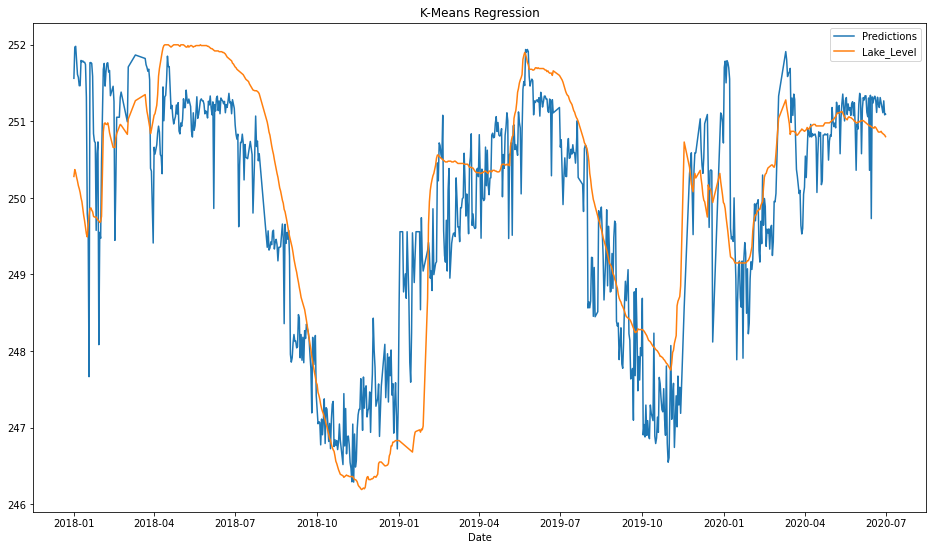

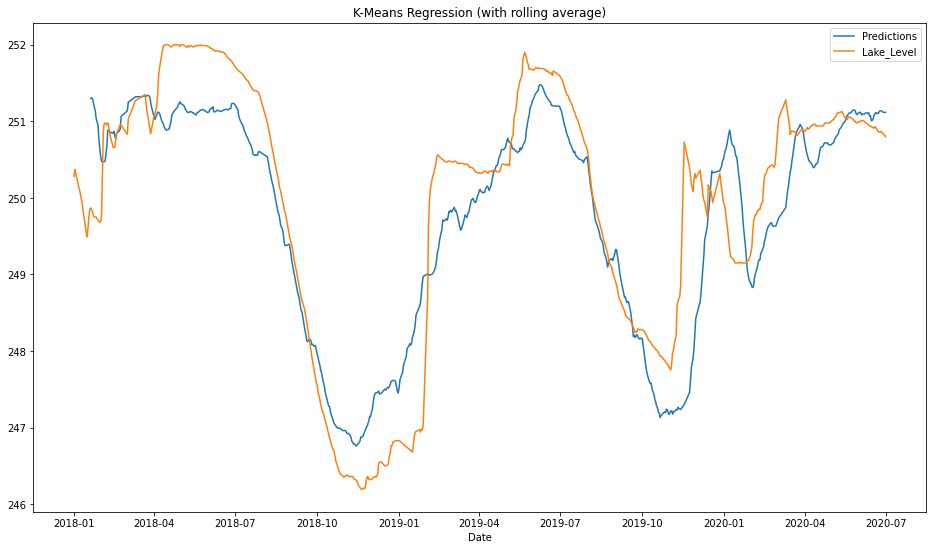

In [12]:
# Observation bigger the K smoother the line
knr = KNeighborsRegressor(n_neighbors=30)

knr_result = run_model(knr)
evaluate(knr_result)
knr_result.plot(title='K-Means Regression', figsize=(16, 9))

print('Adding rolling average over results:')
knr_result['Predictions'] = knr_result['Predictions'].rolling(20).mean()
evaluate(knr_result)
knr_result.plot(title='K-Means Regression (with rolling average)', figsize=(16, 9))

# Sentinel 2 Satalite Images

In [13]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C,
    bands_feature=(FeatureType.DATA, 'BANDS'),
    resolution=10,
    maxcc=0.5,
    bands=['B02', 'B03', 'B04', 'B08'],
    additional_data=[
        (FeatureType.MASK, 'dataMask', 'IS_DATA'),
        (FeatureType.MASK, 'CLM'),
        (FeatureType.MASK, 'CLP'),
    ],
    config=sh_config
)

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):

    def execute(self, eopatch):
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        coverage = np.apply_along_axis(calculate_coverage, 1, valid_data.reshape((time, height * width * channels)))
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch

add_coverage = AddValidDataCoverage()

cloud_coverage_threshold = 0.05

class ValidDataCoveragePredicate:

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold

remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), ValidDataCoveragePredicate(cloud_coverage_threshold))

In [14]:
lake_Bilanino_dir = './data/02_EO_Lake_Bilancino'

time_interval = ('2015-10-01', '2021-01-01')
# Whole Lake
# geoPointBotLeft=(43.97045396264973, 11.235303869212837)
# geoPointTopRight=(43.99936511447475, 11.291311279872092)

geoPointBotLeft=(43.97045396264973, 11.235303869212837)
geoPointTopRight=(43.99936511447475, 11.291311279872092)
roi_bbox = BBox(bbox=[geoPointBotLeft[1], geoPointBotLeft[0], geoPointTopRight[1], geoPointTopRight[0]], crs=CRS.WGS84)

eopatch = EOPatch.load(lake_Bilanino_dir)
if len(eopatch.data) == 0:
    print('Downloading eopatch data from Sentinel hub')
    workflow = LinearWorkflow(
        download_task,
        calculate_ndwi,
        add_valid_mask,
        add_coverage,
        remove_cloudy_scenes,
    )

    result = workflow.execute({ download_task: { 'bbox': roi_bbox, 'time_interval': time_interval } })
    eopatch = result.eopatch()
    eopatch.save(lake_Bilanino_dir, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)
else:
    print('eopatch data was loaded from local directory')

eopatch

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(105, 333, 440, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(105, 333, 440, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(105, 333, 440, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(105, 333, 440, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(105, 333, 440, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(105, 333, 440, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(105, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'processing'
    size_x: 440
    size_y: 333
    time_difference: datetime.timedelta(seconds=1)
    time_interval: ('2015-10-01T00:00:00', '2021-01-01T23:59:59')
  }
  bbox: BBox(((11.235303869212837, 43.97045396264973), (11.291311279872092, 43.99936511447475)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2015, 12, 

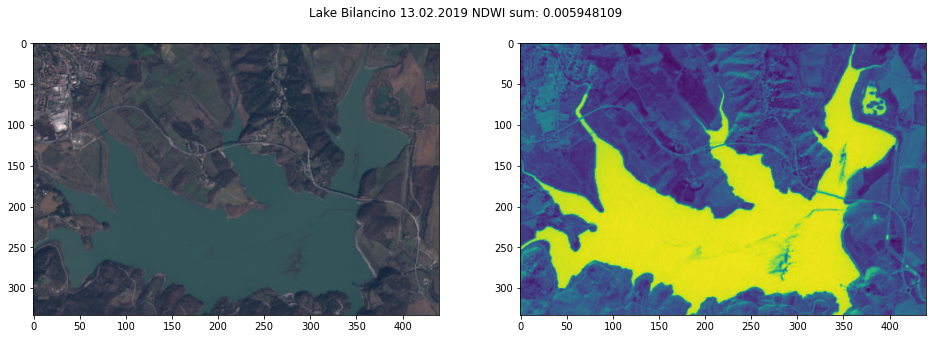

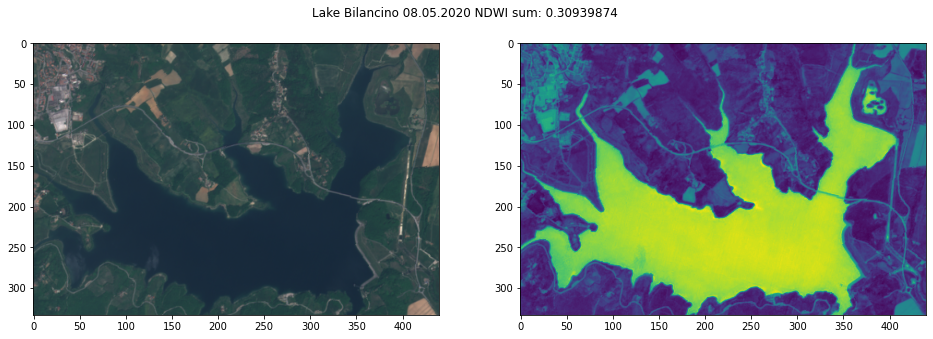

In [15]:
NDWI = np.copy(eopatch.data['NDWI'][...,0]) # unpack 4h dimensions
NDWI = NDWI.reshape(len(NDWI), -1) # 3D (picture, X, Y) => 2D (picture, X & Y values)

eo = pd.DataFrame({ 
    'Date': eopatch.timestamp,
    'Satelit_Levels': NDWI.mean(axis=1) * -1, # majority is non water so we 
})

eo['Date'] = pd.to_datetime(eo['Date']).dt.date
eo = eo.set_index('Date')

def visualise_lake(image_i):
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
        
    suptitle = 'Lake Bilancino {} NDWI sum: {}'.format(
        eopatch.timestamp[image_i].strftime("%d.%m.%Y"),
        str(eo.iloc[image_i, 0]),
    )
    
    fig.suptitle(suptitle)

    rgb=np.clip(eopatch.data['BANDS'][image_i][..., [2,1,0]] * 3, a_min=0, a_max=1)
    axarr[0].imshow(rgb, vmin=0, vmax=1, aspect='auto')
    axarr[1].imshow(eopatch.data['NDWI'][image_i][..., 0], aspect='auto')

visualise_lake(eo['Satelit_Levels'].argmin())
visualise_lake(eo['Satelit_Levels'].argmax())

Lake_Level        1651
Satelit_Levels     105
dtype: int64


,Lake_Level,Satelit_Levels
Lake_Level,1.000000,0.470686
Satelit_Levels,0.470686,1.000000


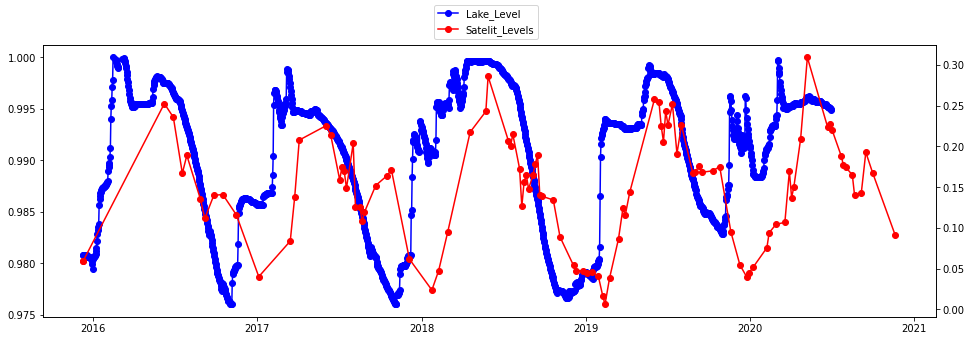

In [16]:
real_values=df.loc[df.index >= min(eopatch.timestamp).date(), ['Lake_Level']]
real_values['Lake_Level'] = real_values['Lake_Level'] / max(real_values['Lake_Level'])

merged = real_values.join(eo, how='outer')

fig, ax1 = plt.subplots(1, 1, figsize=(16, 5))
ax1.plot(merged['Lake_Level'], color='blue', linestyle='-', marker='o', label='Lake_Level')

satelit_levels = merged['Satelit_Levels'][np.isfinite(merged['Satelit_Levels'])]
ax2 = ax1.twinx()
ax2.plot(satelit_levels, color='red', linestyle='-', marker='o', label='Satelit_Levels')
fig.legend(loc='upper center')

print(merged.count())

merged.corr(method='pearson')